### Required Packages: 
Numpy, Numba and Pytorch

### Running this Notebook
Set the hyperparameters in cell [2]

In [1]:
import os
import sys
import time
import logging
import argparse
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F

from data import Data
from net import Net

import baselines

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

### Set the hyperparamters here. 
The models for prob = 0.2, corr = 0.25 and $\lambda = [0,1,2,...,10]$ are already provided. If you are running this plot for a new setting, make sure models corresponding to $\lambda, prob, corr$ are already trained.   

We plot the results for a small sample here (20 x 256 = 5120 samples). 

In the paper, we report results on a much higher number of sample (200 x 1024 = 204800)

In [2]:
class HParams:
    def __init__(self):
        self.num_agents = 4
        self.batch_size = 1024
        self.num_hidden_layers = 4
        self.num_hidden_nodes = 256
        self.num_val_batches = 10
        
        # Higher probability => More truncation
        self.prob = 0.2
        # Higher lambd => More stability
        self.lambd = -1
        # Correlation of rankings
        self.corr = 0.25
        # Run seed
        self.seed = 0
        
        
# Initialize config
cfg = HParams()
device = "cuda:0"
np.random.seed(cfg.seed)

# Set the points to plot.
lambdas = np.linspace(0, 1, 11)

In [3]:
def torch_var(x): return torch.Tensor(x).to(device)

# Loss functions
def compute_st(r, p, q):        
    wp = F.relu(p[:, :, None, :] - p[:, :, :, None])
    wq = F.relu(q[:, :, None, :] - q[:, None, :, :], 0)  
    t = (1 - torch.sum(r, dim = 1, keepdim = True))
    s = (1 - torch.sum(r, dim = 2, keepdim = True))
    rgt_1 = torch.einsum('bjc,bijc->bic', r, wq) + t * F.relu(q)
    rgt_2 = torch.einsum('bia,biac->bic', r, wp) + s * F.relu(p)
    regret =  rgt_1 * rgt_2 
    return regret.sum(-1).sum(-1).mean()/cfg.num_agents

def compute_ir(r, p, q):
    ir_1 = r * F.relu(-q)
    ir_2 = r * F.relu(-p)
    ir = ir_1 + ir_2
    return ir.sum(-1).sum(-1).mean()/cfg.num_agents


def compute_ic(r, p, q, P, Q):
            
    IC_viol_P = torch.zeros(cfg.num_agents).to(device)
    IC_viol_Q = torch.zeros(cfg.num_agents).to(device)

    utility_true_P = (r * p).sum(-1)
    utility_true_Q = (r * q).sum(-2)

    for agent_idx in range(cfg.num_agents):


        P_mis, Q_mis = G.generate_all_misreports(P, Q, agent_idx = agent_idx, is_P = True, include_truncation = True)
        p_mis, q_mis = torch_var(P_mis), torch_var(Q_mis)
        r_mis = model(p_mis.view(-1, cfg.num_agents, cfg.num_agents), q_mis.view(-1, cfg.num_agents, cfg.num_agents))
        r_mis = r_mis.view(*P_mis.shape)

        utility_mis = (r_mis[:, :, agent_idx, :] * p[:, agent_idx, :].unsqueeze(1)).sum(-1).max(-1)[0]
        IC_viol_P[agent_idx] += F.relu(utility_mis - utility_true_P[:, agent_idx]).mean()

        P_mis, Q_mis = G.generate_all_misreports(P, Q, agent_idx = agent_idx, is_P = False, include_truncation = True)
        p_mis, q_mis = torch_var(P_mis), torch_var(Q_mis)
        r_mis = model(p_mis.view(-1, cfg.num_agents, cfg.num_agents), q_mis.view(-1, cfg.num_agents, cfg.num_agents))
        r_mis = r_mis.view(*P_mis.shape)

        utility_mis = (r_mis[:, :, :, agent_idx] * q[:, :, agent_idx].unsqueeze(1)).sum(-1).max(-1)[0]
        IC_viol_Q[agent_idx] +=  F.relu(utility_mis - utility_true_Q[:, agent_idx]).mean()

    IC_viol = (IC_viol_P.mean() + IC_viol_Q.mean())*0.5
    return IC_viol

def compute_ic_FOSD(r, p, q, P, Q, r_mult = 1):
            
    IC_viol_P = torch.zeros(cfg.num_agents).to(device)
    IC_viol_Q = torch.zeros(cfg.num_agents).to(device)
    
    discount = torch_var((r_mult) ** np.arange(cfg.num_agents))

    for agent_idx in range(cfg.num_agents):

        P_mis, Q_mis = G.generate_all_misreports(P, Q, agent_idx = agent_idx, is_P = True, include_truncation = True)
        p_mis, q_mis = torch_var(P_mis), torch_var(Q_mis)
        r_mis = model(p_mis.view(-1, cfg.num_agents, cfg.num_agents), q_mis.view(-1, cfg.num_agents, cfg.num_agents))
        r_mis = r_mis.view(*P_mis.shape)

        r_diff = (r_mis[:, :, agent_idx, :] - r[:, None, agent_idx, :])*(p[:, None, agent_idx, :] > 0).float()
        _, idx = torch.sort(-p[:, agent_idx, :])
        idx = idx[:, None, :].repeat(1, r_mis.size(1), 1)
        
        fosd_viol = torch.cumsum(torch.gather(r_diff, -1, idx) * discount, -1)
        IC_viol_P[agent_idx] = F.relu(fosd_viol).max(-1)[0].max(-1)[0].mean(-1)

        P_mis, Q_mis = G.generate_all_misreports(P, Q, agent_idx = agent_idx, is_P = False, include_truncation = True)
        p_mis, q_mis = torch_var(P_mis), torch_var(Q_mis)
        r_mis = model(p_mis.view(-1, cfg.num_agents, cfg.num_agents), q_mis.view(-1, cfg.num_agents, cfg.num_agents))
        r_mis = r_mis.view(*Q_mis.shape)
        
        r_diff = (r_mis[:, :, :, agent_idx] - r[:, None, :, agent_idx])*(q[:, None, :, agent_idx] > 0).float()
        _, idx = torch.sort(-q[:, :, agent_idx])
        idx = idx[:, None, :].repeat(1, r_mis.size(1), 1)
        
        fosd_viol = torch.cumsum(torch.gather(r_diff, -1, idx) * discount, -1)
        IC_viol_Q[agent_idx] = F.relu(fosd_viol).max(-1)[0].max(-1)[0].mean(-1)

    IC_viol = (IC_viol_P.mean() + IC_viol_Q.mean())*0.5
    return IC_viol

In [4]:
# Loss functions numpy
def STABILITY_VIOLATION_BATCH(P, Q, R):
    WP = np.maximum(P[:, :, np.newaxis, :] - P[:, :, :, np.newaxis], 0)
    WQ = np.maximum(Q[:, :, np.newaxis, :] - Q[:, np.newaxis, :, :], 0)   
       
    T = (1 - np.sum(R, axis = 1, keepdims = True))
    S = (1 - np.sum(R, axis = 2, keepdims = True))
    
    RGT_1 = np.einsum('bjc,bijc->bic', R, WQ) + T * np.maximum(Q, 0)
    RGT_2 = np.einsum('bia,biac->bic', R, WP) + S * np.maximum(P, 0)
    
    REGRET =  RGT_1 * RGT_2 
    
    return REGRET.sum(-1).sum(-1).mean()/cfg.num_agents

def IR_VIOLATION_BATCH(P, Q, R):
    IR_1 = R * np.maximum(-Q, 0)
    IR_2 = R * np.maximum(-P, 0)
    IR = IR_1 + IR_2
    return IR.sum(-1).sum(-1).mean()/cfg.num_agents

def IC_FOSD_VIOLATION_BATCH(P, Q, R, mechanism, r_mult = 1.0):
    
    IC_viol_P = np.zeros(cfg.num_agents)
    IC_viol_Q = np.zeros(cfg.num_agents)
    
    discount = r_mult ** np.arange(cfg.num_agents)

    for agent_idx in range(cfg.num_agents):
        P_mis, Q_mis = G.generate_all_misreports(P, Q, agent_idx = agent_idx, is_P = True, include_truncation = True)
        R_mis = mechanism(P_mis.reshape(-1, cfg.num_agents, cfg.num_agents),
                                 Q_mis.reshape(-1, cfg.num_agents, cfg.num_agents))
        R_mis = R_mis.reshape(cfg.batch_size, -1, cfg.num_agents, cfg.num_agents)

        
        R_diff = (R_mis[:, :, agent_idx, :] - R[:, None, agent_idx, :])*(P[:, None, agent_idx, :] > 0)
        IDX = np.argsort(-P[:, agent_idx, :])
        IDX = np.tile(IDX[:, None, :], (1, R_mis.shape[1], 1))
        
        FOSD_viol = np.cumsum(np.take_along_axis(R_diff, IDX, axis=-1) * discount, -1)
        IC_viol_P[agent_idx] = np.maximum(FOSD_viol, 0).max(-1).max(-1).mean(-1)
        
        P_mis, Q_mis = G.generate_all_misreports(P, Q, agent_idx = agent_idx, is_P = False, include_truncation = True)
        R_mis = mechanism(P_mis.reshape(-1, cfg.num_agents, cfg.num_agents),
                                 Q_mis.reshape(-1, cfg.num_agents, cfg.num_agents))
        R_mis = R_mis.reshape(cfg.batch_size, -1, cfg.num_agents, cfg.num_agents)

        R_diff = (R_mis[:, :, :, agent_idx] - R[:, None, :, agent_idx])*(Q[:, None, :, agent_idx] > 0)
        IDX = np.argsort(-Q[:, :, agent_idx])
        IDX = np.tile(IDX[:, None, :], (1, R_mis.shape[1], 1))
        
        FOSD_viol = np.cumsum(np.take_along_axis(R_diff, IDX, axis=-1)*discount, -1)
        IC_viol_Q[agent_idx] = np.maximum(FOSD_viol, 0).max(-1).max(-1).mean(-1)
        
    IC_viol = (IC_viol_P.mean() + IC_viol_Q.mean())*0.5
    return IC_viol

In [5]:
# Data
G = Data(cfg)

# Neural Network
model = Net(cfg)
model.to(device)

Net(
  (input_block): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
  )
  (layer_out_r): Linear(in_features=256, out_features=20, bias=True)
  (layer_out_c): Linear(in_features=256, out_features=20, bias=True)
)

#### Compute the Stability and IC violations of neural network mechanism trained using different values of $\lambda$

In [6]:
root_dir = os.path.join("experiments", "agents_%d"%(cfg.num_agents),"corr_%.2f"%(cfg.corr))
seed = 0

IC = np.zeros(len(lambdas))
ST = np.zeros(len(lambdas))

for il, lam in enumerate(lambdas):  
    model_path = os.path.join(root_dir, "MODEL_%d_lambd_%f_prob_%.2f_corr_%.2f"%(seed, lam, cfg.prob, cfg.corr))
    model.load_state_dict(torch.load(model_path))
    np.random.seed(cfg.seed)
    print("Lam: ", lam)
    with torch.no_grad():
        val_st_loss = 0.0
        val_ic_loss = 0.0
        for j in range(cfg.num_val_batches):
            P, Q = G.generate_batch_with_corr(cfg.batch_size)
            p, q = torch_var(P), torch_var(Q)
            r = model(p, q)
            st_loss = compute_st(r, p, q)
            ic_loss = compute_ic_FOSD(r, p, q, P, Q)
            val_st_loss += st_loss.item() 
            val_ic_loss += ic_loss.item()
        val_st_loss = val_st_loss/cfg.num_val_batches
        val_ic_loss = val_ic_loss/cfg.num_val_batches
        print("\t[ST-Loss]: %f, [IC-Loss]: %f"%(val_st_loss, val_ic_loss))
        IC[il] = val_ic_loss
        ST[il] = val_st_loss

Lam:  0.0
	[ST-Loss]: 1.126274, [IC-Loss]: 0.000000
Lam:  0.1
	[ST-Loss]: 0.102921, [IC-Loss]: 0.000000
Lam:  0.2
	[ST-Loss]: 0.102916, [IC-Loss]: 0.000000
Lam:  0.30000000000000004
	[ST-Loss]: 0.051250, [IC-Loss]: 0.004190
Lam:  0.4
	[ST-Loss]: 0.034127, [IC-Loss]: 0.010403
Lam:  0.5
	[ST-Loss]: 0.014721, [IC-Loss]: 0.017523
Lam:  0.6000000000000001
	[ST-Loss]: 0.008958, [IC-Loss]: 0.017083
Lam:  0.7000000000000001
	[ST-Loss]: 0.004374, [IC-Loss]: 0.024158
Lam:  0.8
	[ST-Loss]: 0.001675, [IC-Loss]: 0.016273
Lam:  0.9
	[ST-Loss]: 0.000997, [IC-Loss]: 0.025812
Lam:  1.0
	[ST-Loss]: 0.000107, [IC-Loss]: 0.056685


#### Compute the Stability and IC violations of the worker-proposing and firm-proposing DA

In [7]:
print("Worker-Optimal:")
np.random.seed(cfg.seed)
VAL_ST_LOSS = 0.0
VAL_IC_LOSS = 0.0    
mech = baselines.compute_gsm_batch
for j in range(cfg.num_val_batches):
    if cfg.corr > 0:
        P, Q = G.generate_batch_with_corr(cfg.batch_size)
    else:
        P, Q = G.generate_batch(cfg.batch_size)
    R = mech(P, Q)

    ST_LOSS = STABILITY_VIOLATION_BATCH(P, Q, R) + IR_VIOLATION_BATCH(P, Q, R)
    IC_LOSS = IC_FOSD_VIOLATION_BATCH(P, Q, R, mech, r_mult = 1)
    VAL_ST_LOSS += ST_LOSS
    VAL_IC_LOSS += IC_LOSS

VAL_ST_LOSS = VAL_ST_LOSS/cfg.num_val_batches
VAL_IC_LOSS = VAL_IC_LOSS/cfg.num_val_batches
print("\t[ST-Loss]: %f, [IC-Loss]: %f"%(VAL_ST_LOSS, VAL_IC_LOSS))

GS_P_ST = VAL_ST_LOSS
GS_P_IC = VAL_IC_LOSS


print("Firm-Optimal")
np.random.seed(cfg.seed)
VAL_ST_LOSS = 0.0
VAL_IC_LOSS = 0.0
mech = baselines.compute_gsw_batch
for j in range(cfg.num_val_batches):
    if cfg.corr > 0:
        P, Q = G.generate_batch_with_corr(cfg.batch_size)
    else:
        P, Q = G.generate_batch(cfg.batch_size)
    R = mech(P, Q)

    ST_LOSS = STABILITY_VIOLATION_BATCH(P, Q, R) + IR_VIOLATION_BATCH(P, Q, R)
    IC_LOSS = IC_FOSD_VIOLATION_BATCH(P, Q, R, mech, r_mult = 1)
    VAL_ST_LOSS += ST_LOSS
    VAL_IC_LOSS += IC_LOSS

VAL_ST_LOSS = VAL_ST_LOSS/cfg.num_val_batches
VAL_IC_LOSS = VAL_IC_LOSS/cfg.num_val_batches
print("\t[ST-Loss]: %f, [IC-Loss]: %f"%(VAL_ST_LOSS, VAL_IC_LOSS))

GS_Q_ST = VAL_ST_LOSS
GS_Q_IC = VAL_IC_LOSS


GS_ST = min(GS_P_ST, GS_Q_ST)
GS_IC = min(GS_P_IC, GS_Q_IC)

Worker-Optimal:
	[ST-Loss]: 0.000000, [IC-Loss]: 0.048254
Firm-Optimal
	[ST-Loss]: 0.000000, [IC-Loss]: 0.048254


#### Compute the Stability and IC violations of the RSD Mechanism

Note that IC_LOSS = 0 for the RSD mechanism. You can verify this by uncommenting the lines in the code segement below.

In [8]:
np.random.seed(cfg.seed)
VAL_ST_LOSS = 0.0
VAL_IC_LOSS = 0.0
mech = baselines.compute_rsd_ex_ante_batch
cfg.batch_size = 20
for j in range(cfg.num_val_batches):
    tic = time.time()
    if cfg.corr > 0:
        P, Q = G.generate_batch_with_corr(cfg.batch_size)
    else:
        P, Q = G.generate_batch(cfg.batch_size)
    R = mech(P, Q)
    ST_LOSS = STABILITY_VIOLATION_BATCH(P, Q, R) + IR_VIOLATION_BATCH(P, Q, R)
    #IC_LOSS = IC_FOSD_VIOLATION_BATCH(P, Q, R, mech, r_mult = 1)
    VAL_ST_LOSS += ST_LOSS
    #VAL_IC_LOSS += IC_LOSS

VAL_ST_LOSS = VAL_ST_LOSS/cfg.num_val_batches
VAL_IC_LOSS = VAL_IC_LOSS/cfg.num_val_batches

RSD_ST = VAL_ST_LOSS
RSD_IC = VAL_IC_LOSS
print("RSD:")
print("\t[ST-Loss]: %f, [IC-Loss]: %f"%(RSD_ST, RSD_IC))

RSD:
	[ST-Loss]: 0.101079, [IC-Loss]: 0.000000


#### Plot the points on the frontier

Text(0.5, -0.05, 'Stability Violation')

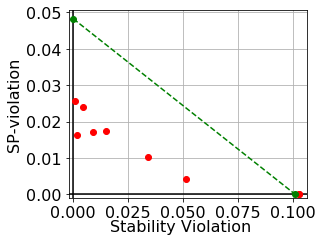

In [9]:
f,ax = plt.subplots(1,1, facecolor='w', figsize=(4, 3))
f.tight_layout(pad = 0.0)
matplotlib.rcParams.update({'font.size': 15})

ax.grid()


ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_ylabel("SP-violation", fontsize=16)

#ax.plot(ST, IC, linewidth = 3.0, color = "b")
ax.plot(ST, IC, "ro", markersize = 6.0)
ax.plot(GS_ST, GS_IC, "go", markersize = 6.0)
ax.plot(RSD_ST, RSD_IC, "go", markersize = 6.0)


ax.plot([0, RSD_ST], [GS_IC, 0], "g", ls = "dashed")
ax.set_xlim([-RSD_ST*0.02, RSD_ST*(1.05)])
ax.set_ylim([-GS_IC*0.02, GS_IC*(1.05)])

f.text(0.5, -0.05, 'Stability Violation', ha='center', size = 16)

#### Compute the welfare, similarity to DA and Normalized Entropy of neural network mechanisms trained using different values of $\lambda$

In [10]:
WF = np.zeros(len(lambdas))
SM = np.zeros(len(lambdas))
EN = np.zeros(len(lambdas))

def plogp(x):
    return - x * np.log2(np.maximum(x, 1e-8))

root_dir = os.path.join("experiments", "agents_%d"%(cfg.num_agents), "corr_%.2f"%(cfg.corr ))
seed = 0

for il, lam in enumerate(lambdas):  
    model_path = os.path.join(root_dir, "MODEL_%d_lambd_%f_prob_%.2f_corr_%.2f"%(seed, lam, cfg.prob, cfg.corr))
    model.load_state_dict(torch.load(model_path))
    np.random.seed(cfg.seed)
    print("Lam: ", lam)
    
    with torch.no_grad():
        wel = 0.0
        sim = 0.0
        simp = 0.0
        simq = 0.0
        ent = 0.0
        for j in range(cfg.num_val_batches):
            P, Q = G.generate_batch_with_corr(cfg.batch_size)
            p, q = torch_var(P), torch_var(Q)
            r = model(p, q)
            R = r.detach().cpu().numpy()
            wel += (P * R + Q * R).sum()/(cfg.batch_size * cfg.num_agents * 2)
            GS_P = baselines.compute_gsm_batch(P, Q)
            GS_Q = baselines.compute_gsw_batch(P, Q)          
            
            sim_P = 2*(GS_P * R).sum(-1).sum(-1) + ((1 - GS_P.sum(-1)) * (1 - R.sum(-1))).sum(-1) + ((1 - GS_P.sum(-2)) * (1 - R.sum(-2))).sum(-1)
            sim_Q = 2*(GS_Q * R).sum(-1).sum(-1) + ((1 - GS_Q.sum(-1)) * (1 - R.sum(-1))).sum(-1) + ((1 - GS_Q.sum(-2)) * (1 - R.sum(-2))).sum(-1)
            
            simp += sim_P.mean()/(2*cfg.num_agents)
            simq += sim_Q.mean()/(2*cfg.num_agents)
            H = plogp(R).sum(-1).sum(-1) + 0.5 * plogp(1 - R.sum(-1)).sum(-1) + 0.5 * plogp(1 - R.sum(-2)).sum(-1)
            ent += H.mean()/cfg.num_agents/-np.log2(1/(cfg.num_agents + 1))
        
        sim = np.maximum(simp, simq)
        sim = sim/cfg.num_val_batches
        wel = wel/cfg.num_val_batches
        ent = ent/cfg.num_val_batches
        print("[Welfare]: %f, [Sim]: %f, [EN]: %f"%(wel, sim, ent))
        WF[il] = wel
        SM[il] = sim
        EN[il] = ent

Lam:  0.0
[Welfare]: 0.000360, [Sim]: 0.147628, [EN]: 0.003513
Lam:  0.1
[Welfare]: 0.486858, [Sim]: 0.326295, [EN]: 0.745502
Lam:  0.2
[Welfare]: 0.486864, [Sim]: 0.326298, [EN]: 0.745451
Lam:  0.30000000000000004
[Welfare]: 0.540901, [Sim]: 0.421424, [EN]: 0.694887
Lam:  0.4
[Welfare]: 0.558047, [Sim]: 0.466388, [EN]: 0.651362
Lam:  0.5
[Welfare]: 0.586749, [Sim]: 0.576952, [EN]: 0.559901
Lam:  0.6000000000000001
[Welfare]: 0.599639, [Sim]: 0.652033, [EN]: 0.490241
Lam:  0.7000000000000001
[Welfare]: 0.613857, [Sim]: 0.776505, [EN]: 0.368076
Lam:  0.8
[Welfare]: 0.633132, [Sim]: 0.980381, [EN]: 0.010559
Lam:  0.9
[Welfare]: 0.636012, [Sim]: 0.968353, [EN]: 0.006840
Lam:  1.0
[Welfare]: 0.638938, [Sim]: 0.950580, [EN]: 0.005597


#### Compute the welfare achieved by the best of work-proposing and firm-proposing DA mechanism

In [11]:
np.random.seed(cfg.seed)
VAL_WF = 0.0
print("Worker-Optimal:")
for j in range(cfg.num_val_batches):
    P, Q = G.generate_batch_with_corr(cfg.batch_size)
    R = baselines.compute_gsm_batch(P, Q)
    VAL_WF += (P*R + Q*R).sum()/(cfg.batch_size * cfg.num_agents * 2)
VAL_WF = VAL_WF/cfg.num_val_batches
print("\t[WF]: %f"%(VAL_WF))
DA_WF = VAL_WF

print("Firm-Optimal")
VAL_WF = 0.0
np.random.seed(cfg.seed)
for j in range(cfg.num_val_batches):
    P, Q = G.generate_batch_with_corr(cfg.batch_size)
    R = baselines.compute_gsw_batch(P, Q)
    VAL_WF += (P*R + Q*R).sum()/(cfg.batch_size * cfg.num_agents * 2)
VAL_WF = VAL_WF/cfg.num_val_batches
print("\t[WF]: %f"%(VAL_WF))

DA_WF = max(DA_WF, VAL_WF)

Worker-Optimal:
	[WF]: 0.636875
Firm-Optimal
	[WF]: 0.637344


#### Compute the welfare achieved by the best of work-proposing and firm-proposing RSD mechanism

In [12]:
np.random.seed(cfg.seed)
VAL_WF = 0.0
for j in range(cfg.num_val_batches):
    P, Q = G.generate_batch_with_corr(cfg.batch_size)
    R = baselines.compute_rsd_ex_ante_batch(P, Q)
    VAL_WF += (P*R + Q*R).sum()/(cfg.batch_size * cfg.num_agents * 2)

VAL_WF = VAL_WF/cfg.num_val_batches
print("RSD:")
print("\t[WF]: %f"%(VAL_WF))
    
RSD_WF = VAL_WF

RSD:
	[WF]: 0.583640


#### Plot comparing the welfare achieved by neural network mechanisms trained using different values of $\lambda$

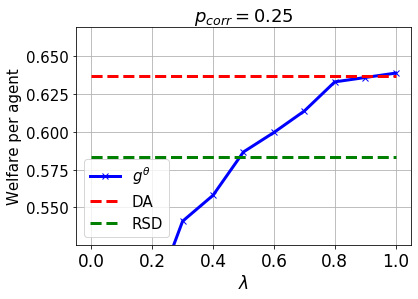

In [13]:
plt.plot(lambdas, WF, lw = 3.0, marker='x', c = "b", label = r"$g^{\theta}$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 17)
plt.xticks(fontsize = 17)
plt.ylabel("Welfare per agent")
plt.plot([0, 1], [DA_WF, DA_WF], lw = 3.0, c = "r", ls = "dashed", label = "DA")
plt.plot([0, 1], [RSD_WF, RSD_WF], lw = 3.0, c = "g", ls = "dashed", label = "RSD")
plt.title("$p_{corr} = %.2f$"%(cfg.corr))
plt.ylim([min(DA_WF, RSD_WF)*0.9, max(DA_WF, RSD_WF)*1.05])
_ = plt.legend()

#### Plot comparing the degree of similarity to DA of neural network mechanisms trained using different values of $\lambda$

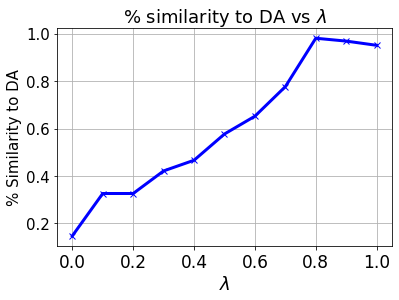

In [14]:
plt.plot(lambdas, SM, c = "b", lw = 3.0, marker='x', label = r"$Uncorrelated$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 18)
plt.xticks(fontsize = 17)
plt.ylabel("% Similarity to DA")
_ = plt.title("% similarity to DA vs $\lambda$")

#### Plot comparing the normalized entropy of neural network mechanisms trained using different values of $\lambda$

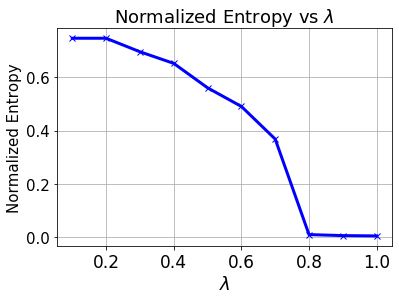

In [15]:
plt.plot(lambdas[1:], EN[1:], c = "b", lw = 3.0, marker='x', label = r"$Uncorrelated$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 18)
plt.xticks(fontsize = 17)
plt.ylabel("Normalized Entropy")
_ = plt.title("Normalized Entropy vs $\lambda$")